Мета:

Створити просту генеративно-змагальну мережу (GAN) для генерації зображень, використовуючи набір даних MNIST, який складається з рукописних цифр.

Кроки для виконання завдання:

1. Завантаження та попередня обробка даних:
  * Завантажте набір даних MNIST (він доступний як в TensorFlow, так і в PyTorch).
  * Нормалізуйте значення пікселів до діапазону [-1, 1], що покращить процес навчання GAN.
2. Створення архітектури генератора:
  * Створіть генератор, який приймає випадковий шум на вході (наприклад, вектор розміром 100).
  * Генератор може складатися з декількох шарів (Dense) з функціями активації ReLU і завершуватись вихідним шаром із функцією активації tanh, щоб генерувати зображення розміром 28x28.
3. Створення архітектури дискримінатора:
  * Створіть дискримінатор, який приймає зображення розміром 28x28 як вхід.
  * Дискримінатор може складатися з декількох повнозв’язних шарів (Dense) з функціями активації LeakyReLU.
  * Останній шар має мати один вихід із функцією активації sigmoid для визначення, чи є зображення реальним чи згенерованим.
4. Налаштування втрат та оптимізаторів:
  * Виберіть функцію втрат binary cross-entropy для обох мереж.
  * Виберіть оптимізатори, такі як Adam, з відповідними коефіцієнтами навчання (зазвичай 0.0002).
5. Об’єднання моделей та навчання GAN:
  * Навчайте дискримінатор окремо, використовуючи реальні зображення MNIST та згенеровані зображення від генератора.
  * Після кожного оновлення дискримінатора, навчайте генератор з метою "обдурити" дискримінатор.
  * Виконайте процес навчання в декілька епох, генеруючи зображення на кожній епосі для оцінки прогресу.
6. Оцінка та візуалізація результатів:
  * Після кожної епохи або кількох епох візуалізуйте згенеровані зображення, щоб бачити покращення.
  * Збережіть найкращі згенеровані зображення та модель генератора для подальшого використання.
7. Підведення підсумків:
  * Опишіть отримані результати, зокрема, як змінювались згенеровані зображення протягом навчання.
  * Проаналізуйте, чи вдалося досягти реалістичних зображень цифр, та які аспекти можна було б покращити в моделі.

Мінімальні вимоги:

* Створити та навчити простий GAN на наборі даних MNIST.
* Досягти генерації зображень, які схожі на рукописні цифри.

Формат виконання: 

.ipynb блокнот з кодом та візуалізацією, або ж код в .py з прикріпленими зображеннями результатів на гітхабі.

In [4]:
# Встановіть необхідні бібліотеки: TensorFlow або PyTorch, numpy, matplotlib (для візуалізації).
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Single channel for grayscale
])

dataset_dataset = torchvision.datasets.MNIST(
    root='./data', 
    train=True,
    download=True,
    transform=transform
)

dataset_loader = torch.utils.data.DataLoader(dataset_dataset, batch_size=64, shuffle=True)

In [6]:
latent_dim = 100
image_size = 28*28*3

# Define the Generator's architecture
G = nn.Sequential(
    nn.Linear(latent_dim, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),  # 28*28 = 784 for MNIST
            nn.Tanh()
).to(device)


D = nn.Sequential(
    nn.Flatten(),
            nn.Linear(784, 512),  # 28*28 = 784 for MNIST input
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
).to(device)
     

In [7]:
criterion = nn.BCELoss()

# Optimizers
G_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [8]:
def plot_generated_images(G, epoch, latent_dim, device):
    with torch.no_grad():
        z = torch.randn(16, latent_dim, device=device)
        fake_images = G(z)
        fake_images = fake_images.view(-1, 1, 28, 28)
        fake_images = fake_images.cpu().numpy()
        
        plt.figure(figsize=(10, 10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(fake_images[i, 0], cmap='gray')
            plt.axis('off')
        plt.suptitle(f'Generated Images at Epoch {epoch}')
        plt.show()

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

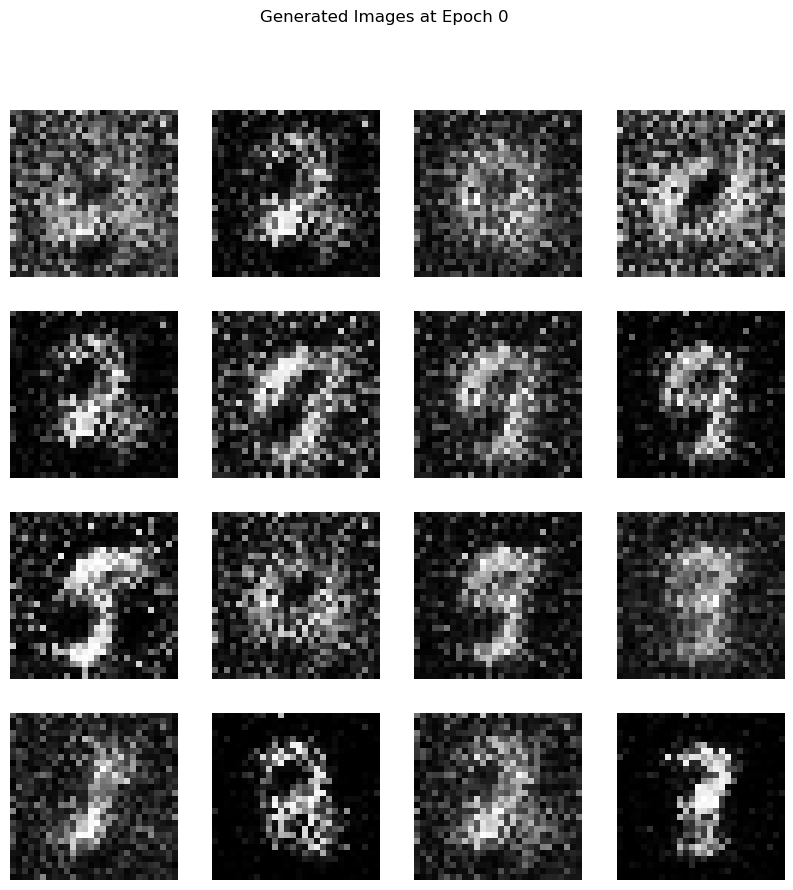

Training Progress:   0%|          | 1/2000 [00:57<31:52:18, 57.40s/it]

Epoch [1/2000], Step [938/938], D_loss: 0.4294, G_loss: 2.7439, D(x): 0.83, D(G(z)): 0.19


Training Progress:   1%|          | 11/2000 [09:55<30:29:46, 55.20s/it]

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

writer = SummaryWriter('runs/gan_mnist')

num_epochs = 2000

for epoch in tqdm(range(num_epochs), desc="Training Progress"):
    for i, (images, _) in enumerate(dataset_loader):
        images = images.to(device)
        images = images.view(images.size(0), -1)

        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        # Discriminator Training
        D_optimizer.zero_grad()
        outputs = D(images)
        D_loss_real = criterion(outputs, real_labels)
        real_score = outputs

        z = torch.randn(images.size(0), latent_dim, device=device)
        fake_images = G(z)

        outputs = D(fake_images.detach())
        D_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs

        D_loss = D_loss_real + D_loss_fake
        D_loss.backward()
        D_optimizer.step()

        # Generator Training
        G_optimizer.zero_grad()
        z = torch.randn(images.size(0), latent_dim, device=device)
        fake_images = G(z)

        outputs = D(fake_images)
        G_loss = criterion(outputs, real_labels)

        G_loss.backward()
        G_optimizer.step()

        # TensorBoard Logging
        writer.add_scalar('Loss/Discriminator', D_loss.item(), epoch * len(dataset_loader) + i)
        writer.add_scalar('Loss/Generator', G_loss.item(), epoch * len(dataset_loader) + i)
        writer.add_scalar('Score/Real', real_score.mean().item(), epoch * len(dataset_loader) + i)
        writer.add_scalar('Score/Fake', fake_score.mean().item(), epoch * len(dataset_loader) + i)

    if epoch % 100 == 0:
        # Log images to TensorBoard
        with torch.no_grad():
            z = torch.randn(16, latent_dim, device=device)
            fake_images = G(z)
            fake_images = fake_images.view(-1, 1, 28, 28)
            img_grid = torchvision.utils.make_grid(fake_images, normalize=True)
            writer.add_image('Generated Images', img_grid, epoch)
            
        plot_generated_images(G, epoch, latent_dim, device)
        print('Epoch [{}/{}], Step [{}/{}], D_loss: {:.4f}, G_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
              .format(epoch+1, num_epochs, i+1, len(dataset_loader), D_loss.item(), G_loss.item(),
                     real_score.mean().item(), fake_score.mean().item()))

writer.close()
